---
# Homework 2 - eCommerce analytics
---

# Notes before starting

We dealt with a huge amount of data from the files `2019-Oct.csv` and `2019-Nov.csv`. These files have a total size equal to 13,4GB. For all the questions, we reduced the amount of RAM required by loading only the needed columns and, since some columns data allows it, we forced some data casting to data types smaller in size. Specifically, for example, we loaded the `user_id` values as `numpy.int32` instead of default `numpy.int64`, since we observed that `user_id` values are of 10<sup>8</sup> order.

Moreover, we tried to handle these data applying two different strategies. The first one was execute the fucntions in a AWS EC2 instance configured with the proper quantity of RAM. According to the second one, we implemented some functions chunking the dataset, computing by chunk and then combining the results. We are aware that this implementation adds a lot of overhead, but this way we managed to run these functions on a laptop with only 8GB of RAM. These functions are included in the file `./scripts/our_functions` that we chose to use in this notebook. All the questions marked with a **\*** were solved with such functions.

# Setup

As previously mentioned, in order to keep the notebook tidy, for each question, we put the functions in the file `./scripts/our_functions.py`.

In [1]:
import scripts.our_functions as f

Specifically, the libraries we used are the following:

```python
# for data handling and analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import datetime

# utilies for computational performance evaluation and debugging
from tqdm import tqdm
from threading import Thread
from queue import Queue
import os, glob
```

To have an insight into the data handling, we show the routine function to load the needed data for each question: 

```python
def get_needed_iterator(month_files:list, columns:list, chunksize:int=10**6, parse_dates=False):
    global DATA_PATH, dtype
    iterators = []
    date_parser = pd.to_datetime if parse_dates else None
    for month in month_files:
        iterators.append(pd.read_csv(os.path.join(DATA_PATH, month), usecols=columns, 
                                     parse_dates=parse_dates, date_parser=date_parser, 
                                     chunksize=chunksize, dtype=dtype))
    return iterators
```

According to the pandas API, we split the dataset into chunks of 10<sup>6</sup> rows and we obtain an iterator. Using this iterator properly, we get all the data required for each question.

---
# [RQ1]  Which is the rate of complete funnels? *

According to the question statement, a complete funnel involves three steps: 1) view, 2) cart and 3) purchase. Because an event of type *cart* implies (and corresponds to) an event of type *view*, we only select the rows related to a *cart* and *purchase* events. Then, regarding to the *purchase* event, we make a distinction between the purchases after a corresponding *cart* event and the one-click purchases, which don't correspond to a *cart* event. Besides the complete funnels, we consider incomplete funnels the routes {1} (orphan views) and the route {1,2} (orphan carts).

To be clear, the sets that we consider in order to compute the rate of complete funnels are:

$
U = \{\text{all tuples}\}\\
P = \{\text{purchase tuples}\}\\
C = \{\text{cart tuples}\}
$

The set $P - (P \cap C)$ contains only the one-click purchases. So, given the cardinalities

$
|U| = n_{tuples}\\
|P| = n_{purchases}\\
|C| = n_{carts}\\
|P-(P \cap C)| = n_{one-click}
$

we compute the rate of complete funnels without one-click purchases as

$
r_{\%}=\frac{n_{purchases}-n_{one-click}}{n_{tuples}-2\dot(n_{purchases}-n_{one-click})-[n_{carts}-(n_{purchases}-n_{one-click})]-n_{one-click}} = \frac{n_{purchases}-n_{one-click}}{n_{tuples}-n_{purchases}-n_{carts}}
$

Similarly, we compute the rate of complete funnels with one-click purchases.

We show two results, one that corresponds only to the route {1,2,3} and the other that takes into account also the route {1,3} (one-click purchases).

In [4]:
f.complete_funnels(['event_type', 'user_session', 'product_id'])

There are 4979364 purchases,
of which 2784960 one_click purchases (only view-purchase couples).
The number of carts is 11866338.


Rate of complete funnels without one_click purchases:	2.36%.

Rate of complete funnels with one_click purchases:	5.35%.


The results show that the **2.36%** of the funnels, excluding the view-purchase ones, are complete. The interesting outcome is that the rate of complete funnels doubles if taking into account also the one-click purchases (**5.35%**). We deduce that customers often enjoy the one-click route instead of the "traditional" route, maybe thanks to the immediacy of the transaction. 

## What’s the operation users repeat more on average within a session? *

In order to get, for each session and event (*view*, *cart*, *purchase*), the average number of operations performed by users, we need to count the tuples of each event and the number of distinct sessions; then, the rate $\frac{n_{event}}{n_{sessions}}$ is the requested outcome.

9.07 views, 0.34 carts, 0.14 purchases. 23,016,651 sessions.




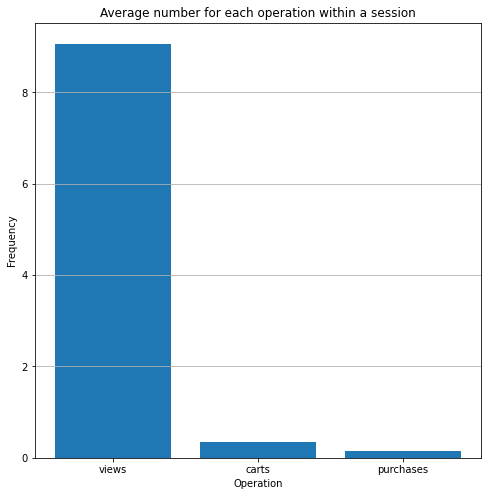

In [2]:
f.average_number_operations(['user_session', 'event_type'])

Observing the plot, it is evident that the number of *views* is far way greater than the number of *carts* and *purchases*; specifically, it is more than 26 and 64 times greater, respectively. This outcome, as expected, confirms the result discussed in the previous sub-point: customers view a lot of products, maybe many times each, before decide to add them to the cart and make a purchase.

## How many times, on average, a user views a product before adding it to the cart? *

To solve this task, the needed attributes are `user_id`, `product_id`, `event_type` and `event_time`. Selecting the sets related to *cart* and *view* events and joining them on `user_id` and `product_id` give the desired result. It is relevant to remark that the attribute `event_time` is crucial to filter the tuples of the joint set according to the condition `event_time_view < event_time_cart` for each `(user_id, product_id)` couple. 

In [7]:
f.average_views_before_cart(['user_id', 'product_id', 'event_type', 'event_time'])

On average a user views a product 10.05 times before adding it to the cart.


As expected by analyzing the plot above, a user views a product **10 times** before adding it to the cart. This is the reason why the *view* event overcomes the others by far.

## What’s the probability that products added once to the cart are effectively bought? *

Let $C$ and $P$ be the events such that

$
C = \{\text{a product is added to the cart}\}\\
P = \{\text{a product is bought}\}.
$

In this task, we are asked to find the probability that products added once to the cart are effectively bought, that is the conditional probability $\mathbb{P}(P|C)$. According to the definition of conditional probability, we have

$
\mathbb{P}(P|C)=\frac{\mathbb{P}(C\cap P)}{\mathbb{P}(C)}.
$

The probability of the event C is

$
\mathbb{P}(C)=\frac{\text{# of cart tuples}}{\text{# of tuples}}=\frac{n_{cart}}{n_{tuples}}.
$

Similarly, the probability of the event $C\cap P$ is

$
\mathbb{P}(C\cap P)=\frac{\text{# of cart tuples corresponding to purchase tuples}}{\text{# of tuples}}=\frac{n_{cart\_purchase}}{n_{tuples}}.
$

Then, the requested probability is $\mathbb{P}(P|C)=\frac{n_{cart\_purchase}}{n_{tuples}}\times\frac{n_{tuples}}{n_{cart}}=\frac{n_{cart\_purchase}}{n_{cart}}$.

In [3]:
f.probability_purchase(['user_session', 'product_id', 'event_type'])

The probability that products added once to the cart are effectively bought is 65.17%.


As the result points out, more than **1 addition to the cart in 3** is successful. Once again, this result visually finds confirmation in the plot above.

## What’s the average time an item stays in the cart before being removed? *

For this task, we came up with an estimation of the average time an item stays in the cart before being removed. Indeed, despite the [description of the data](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Oct.csv) and according to [this punctualization](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store/discussion/132470#757896), there is no *removefromcart* event. Then, observing the behaviour of some famous e-commerce stores, we assumed that the cart state lives within a session; this means that when the session expires, the cart is deleted. In other words, the cart state is session-bound. 

To approximate the session expiration, we pick the last operation within each session, that is the operation with the maximum timestamp within the session. Performing the timestamp difference between a cart event and the corresponding last session operation, we are able to compute the desired average time.

In [ ]:
f.average_time_cart(['event_type', 'user_session', 'product_id', 'event_time'])

## How much time passes on average between the first view time and a purchase/addition to cart? *

Thanks to the generic question of this task, we decided to analyze two different cases in order to highlight some characteristics of the customers.

The first case we dealt with is considering the average time between the very first view of a user and her very first addition to the cart/purchase. In other words, we chose to measure how much time a user takes before generating a profit.

In [2]:
f.average_time_after_first_view_1(['event_type', 'event_time', 'user_id'])

The average time between the first view time and a purchase/addition to cart is 128.89 hours.
The standard deviation is 268.74 hours.


To be more aware of the amount of time, we convert the result into days:

In [3]:
print(f'The average time between the first view time and a purchase/addition to cart is {round(128.89 / 24)} days.')
print(f'The standard deviation is {round(268.74 / 24)} days.')

The average time between the first view time and a purchase/addition to cart is 5 days.
The standard deviation is 11 days.


On average, a user generates a profit **5 days** after she learnt about our business, which is pretty much! The standard deviation of **11 days** points out that there are some outliers in the delta-time distribution: probably, there are some users who view and add/buy a product immediately and others that add/buy a product after many weeks.

In the second case we analyzed, we considered the average time between the very first view of a specific product by a user and its corresponding addition to the cart/purchase. To be clear, we estimated how much time a user takes before deciding to buy a specific product she previuosly saw. We filtered the tuples by the attribute `user_id` instead of `user_session` because a user may view a product for the first time during one session and add it to the cart/purchase it during another session. 

In [ ]:
f.average_time_after_first_view_2(['event_type', 'event_time', 'user_id', 'product_id'])

43it [06:18,  8.79s/it]
26it [03:43,  8.87s/it]

---
# [RQ2]  What are the categories of the most trending products overall? *

We produced a plot showing the number of sold products per category: obtaining a subset of only the purchases, we grouped by category code, and counted the number of sold product plotting the biggest 10 values

In [2]:
f.num_sold_per_cat()

FileNotFoundError: [Errno 2] File ./data/2019-Oct.csv does not exist: './data/2019-Oct.csv'

We then plotted the 10 most visited subcategories, obtaining a subset of only the views, grouping by category code and counting the views of each category

In [ ]:
f.most_v_cat()

And eventually we produced a list showing the most sold products per category: obtaining a subset of only the purchases, we counted, for each category code, the number of sold products

In [ ]:
f.most_sold_per_cat()

# [RQ4] How much does each brand earn per month? *

As we were asked, we wrote the following function to get the profit per month given the brand name:

```python
def get_profit_per_month(brand_name, dataset_list:list=None):
    global month_files
    if dataset_list == None:
        dataset_list = get_purchases(['brand', 'product_id', 'price', 'event_type'])
    profit_per_month = {}
    for i in range(len(month_files)):
        profit = 0
        month_name = month_files[i][5:8]
        brand_items = dataset_list[i][dataset_list[i].brand == brand_name]
        if not brand_items.empty:
            profit = brand_items[(brand_items.price.notna()) & 
                                 (brand_items.price.notnull())].price.agg('sum')
        profit_per_month[month_name] = profit
    return profit_per_month
```

The profit of a brand is equal to the sum of the purchases of the brand products. So, we get the *purchase* tuples and we filter on the brand name. This way, the function returns a dictionary containing (month->profit) couples. 

For example, the profit of the brand Samsung is:

In [7]:
profit = f.get_profit_per_month('samsung')
print(f'Samsung earned {profit["Oct"]:,.2f}$ in October and {profit["Nov"]:,.2f}$ in November.')

Samsung earned 46,407,524.00$ in October and 54,869,880.00$ in November.


## Is the average price of products of different brands significantly different? *

To answer to this question, we first compute the mean of the price of the distinct products for each brand; then, we calculate the standard deviation of the means. Indeed, the standard deviation allows us to understand how much the average price of each brand differ from the mean.

In [2]:
brand_means = f.price_std_dev(['brand', 'product_id', 'price'])

The mean of the average price of the products for each brand is 171.71$,
with a standard deviation of 267.11$.


Comparing the mean we obtained with the related standard deviation, we can deduce that the variation inside the average price distribution is pretty relevant. To prove this, we can take the maximum and the minimum average price:

In [4]:
print(f'The minimum average price is:\t{brand_means.min():,.2f}$.\nThe maximum average price is:\t{brand_means.max():,.2f}$.')

The minimum average price is:	0.97$.
The maximum average price is:	2,522.59$.


As shown, there is a huge difference between the maximum and the minimum average price.

## Find the top 3 brands that have suffered the biggest losses in earnings between one month and the next *

We assumed as "biggest losses" the percentage losses between one month and the next. We compute the loss as:

$
l_{\%} = \frac{profit_{nov}-profit_{oct}}{profit_{oct}+1}\times 100
$

We add 1 to $profit_{oct}$ to avoid zero divisions. This implies that, when $profit_{nov}$ is 0, the loss is *almost* 100%, but not exactly 0. We assume that this approximation is negligible.

In [2]:
f.top_n_two_months_losses(['brand', 'product_id', 'price', 'event_type'], 'Oct', 'Nov')

The brand "eltreco" lost 99.99% between Oct and Nov.
The brand "kingsong" lost 99.98% between Oct and Nov.
The brand "erdenet" lost 99.98% between Oct and Nov.


As expected, the top 3 brands that suffered the biggest losses between October and November are minor brands, with small business. Their losses suggest that these 3 brands didn't earn anything (or almost anything) during November. Nevertheless, they may not be those which had the greatest *absolute losses*. To verify this out, we slightly modified the previous function.  

In [3]:
f.top_n_two_months_losses_abs(['brand', 'product_id', 'price', 'event_type'], 'Oct', 'Nov')

The brand "acer" lost 229,413.00$ between Oct and Nov.
The brand "peda" lost 171,063.44$ between Oct and Nov.
The brand "omabelle" lost 145,833.72$ between Oct and Nov.


Indeed, the list of the top 3 brand is now completely different.

---
# [RQ5]  In what part of the day is your store most visited? *

We created a heatmap plot that, for each day of the week, shows the hourly average of visitors the store has

In [3]:
f.havg_visit()

FileNotFoundError: [Errno 2] File ./data/2019-Oct.csv does not exist: './data/2019-Oct.csv'

# [RQ7] Prove that the Pareto principle applies to your store *

According to the Pareto principle, around 80% of the business of the e-commerce platform comes from about 20% of the customers. The keypoint in this task is state a definition of the "platform business". We gave two definitions of it:

1. the total profit coming from the purchases.
2. the number of operations performed within the platform.

While the first case is self-explanatory, the second case needs a little explanation. We considered that the business of an e-commerce platform, that is its profit, may not come only from the purchases, but also from the activities within it; actually, even *view* events may generate some profit thanks to the ads that may be present inside the e-commerce web pages or thanks to the visibility of the products, for which each brand may pay a fee.

According to the previous introduction, in the first case we consider the 20% of the users that have spent the most in the e-commerce platform and we compute the rate between the profit coming from them and the total profit.

In [3]:
f.prove_pareto(['event_type', 'user_id', 'price'])

The 20% of the users is responsible of the 72.0% of the business.


In the second case, we just count how many operations each user performed, sorting them in descent order. Then, we compute the rate between the amount of operations performed by the 20% of the users and the total number of operations performed within the system. 

In [4]:
f.prove_pareto_ops(['user_id'])

The 20% of the users is responsible of the 77.0% of the business.


In both cases, the Pareto principle applies to our store.